# A framework for the comparison of plasmid prediction tools

**Aniket Mane, Cedric Chauve  
Department of Mathematics  
Simon Fraser University**

### Abstract
This notebook describes a simple method to quantify the agreement between two plasmid prediction tools.  
It is applied to the comparison of the prediction of the tools <a href="https://github.com/phac-nml/mob-suite">MOB-suite</a>
and <a href="https://github.com/cchauve/HyAsP">HyAsP</a> on a dataset of 313 *E. faecalis* isolates, sequenced using Illumina short-reads technology.

In [1]:
from datetime import date
print(f"Version of {date.today()}.")

Version of 2021-03-05


## Introduction
Plasmids are important due to their role in the spread of antibiotic resistance through mechanisms such as horizontal gene transfer. 
Various tools have been proposed for the detection and assembly of plasmids from short-reads sequencing data obtained from bacterial isolates. 
Approaches used by plasmid assembly tools can be roughly characterised as de-novo, reference-based or a hybrid of the two. 
Understanding the differences in solutions from different tools can be useful for a comprehensive study of plasmids in a large dataset. 
Typically, plasmid assembly tools provide solutions where plasmids are represented in the form of sets (sometimes linearly or circularly ordered) of contigs. 
Thus, each plasmid is described as a collection of contigs, possibly with repeats, i.e. the same contig can appear in different predicted plasmids, or even in the same plasmid. 
Our aim is to develop a method to compare the sets of plasmids predicted using different tools and to quantify how close the sets are to each other.

## Method

The method we developed takes two sets of plasmids as input. 
Each plasmid is a collection of contigs resulting from the assembly of sequencing data from a bacterial isolate; 
we assume that for a given isolate, a contig will be represented by the same id in both methods. 
Thus a set of predicted plasmids is represented by an unordered set of contigs multi-sets (i.e. a contig can appear several times in a predicted plasmid).

The aim of our method is to compute a set-theoretic dissimilarity measure between the set of plasmids predicted by two methods based on the idea of transforming the predicted plasmids of one tool into the predicted plasmids of the other tool, while accounting for the length of contigs.
Informally the method entails *splitting* plasmids from one set to yield an intermediate set of modified plasmids, representing a consensus between the two starting sets of plasmids.
Every "split" step consists of removing a contig or a set of contigs from a plasmid to form a new set (representing a "plasmid" from the intermediate set). 
Once we obtain the intermediate set, we perform a series of *joins* to obtain the set of plasmids from the other tool. 
Each split or join step involves two sets of contigs and each such step incurs a penalty weighted by the cumulative lengths of contigs in the lengthwise smaller of the two sets of contigs involved. 
This approach is sensitive to contigs occurring only in one set of predicted plasmids, that can naturally not be part of the consensus intermediate step, and as well to contigs appearing with different multiplicity in the two starting sets of predicted plasmids; for example, in this work, HyAsP allows a contig to appear several times in the set of predicted plasmids, while MOB-suite does not.

Our method accounts for both aspects in a way we describe below.
Below we first describe our method in the case where there is no repeated contig, then we describe how we handle repeated contigs.

### Algorithm

We denote by $A$ and $B$ the two sets of predicted plasmids.

#### Method with non unique contig and no repeated contig.
Note that for now we assume first no contig with multiplicity greater than $1$ either in $A$ or $B$.
We also assume that any contig in $A$ appears once and exactly once in both $A$ and $B$, and conversely.

1. Next we build a bipartite graph $G=(A,B,E)$ where the plasmids from one set are represented by the nodes in set $A$ while those from the other set are represented by the nodes in set $B$. If a plasmid from set $A$ contains a contig with the label as a contig that belongs to a plasmid from set $B$, we connect the respective nodes through an edge. All such edges form the edge set $E$. 
2. Consider a connected component of $G$. An edge connects two plasmids - say, $p_A$ from set $A$ and $p_B$ from set $B$. The intersection of $p_A$ and $p_B$ gives us a set of contigs. Thus, each edge identifies a set of contigs common to both nodes it connects. We process each connected component independently.
3. A plasmid $p_A$ from set $A$ can be split into several subsets formed due to all edges incident on $p_A$. We refer to the partitions for plasmids from set $A$ as "maximum intersection sets". Each part of this partition represents a set of contigs that appears together in all plasmids from the other sets in its neighbourhood. 
4. Thus, we split each plasmid from set $A$ into the maximum intersection sets. Each such subset is weighted by the sum of the lengths of the contigs it contains.
5. Once we obtain the maximum intersection sets for all plasmids in $A$, we join the appropriate sets to obtain (i.e. reconstruct) the plasmids in set $B$. This approach is identical to the classical split-join distance to transform a clustering on a ground set into another clustering on the same ground set.
6. The cost of splitting a plasmid from set $A$ into $k$ subsets is defined as the sum of the weights of the $k-1$ lowest weight sets of the partition resulting from the splits.
7. Similarly, the cost of joining to form a plasmid of set $B$ is equivalent to the sum of the weights of the $k-1$ lowest weight sets involved in the join. The rationale to consider the lowest weights sets involved in splits and joins is to rely on a parsimony principle.

After this last step, we have thus a cost associated to the transformation of the plasmids from $A$ into the plasmids of $B$, that we normalize by dividing it by the sum of the lengths of all contigs (remember they were common to both $A$ and $B$). 
This provides a measure of dissimilarity between the two sets of predicted plasmids based on the minimum amount of transformation needed to transform one into the other. Note that this measure is symmetric in the sense that it does not depend on the choice of which starting set of plasmids is identified as $A$ or $B$. A dissimilarity of $0$ indicates that $A$ anb $B$ were identical.

This step can naturally be implemented in linear time in the number of contigs present in $A$ and $B$.

#### Handling non-common contigs

To incorporate contigs appearing within only $A$ or $B$, we procee as follows.
Prior to building the bipartite graph $G$, we discard from $A$ any contig that does not appear in $B$ and conversely.
We consider that this initial step of discarding contigs prior to constructing the graph amounts to a single split (for $A$) or join (for $B$) weighted by the sum of the lengths of all such contigs. 
Then when we normalize, we add the sum of the lengths of such contigs both in the score and in the normalizing term.

#### Handling repeated contigs

If some contig appears more than once in a given set of predicted plasmids, our approach consists in labelling each occurrence with a specific label in both sets of predicted plasmids.
Assume the number of copies for a common contig $C$ is $m$ and $n$ respectively for both input sets of plasmids. 
If $m > n$, we arbitrarily relabel the contig copies in one set as $C_1, C_2,..., C_m$ and in the other set as $C_1, C_2,..., C_n$. 
After this relabeling step, the various copies of $C$ are not different in both sets and we can apply the method described above.
The resulting dissimilarity measure depends heavily from the chosen labelling.
To follow the parsimony principle, we use a brute-force approach that considers all possible such relabellings of repeated contigs and we chose a relabelling that optimizes the resulting dissimilarity measure. 
This approach has obviously an exponential time complexity, but we observed in our experiments that the combinatorics of considering all possible labellings is highly manageable.

### Interpreting the results

The method gives us three types of information as output:
1. The similarity score,
2. The labelling of repeated contigs,
3. A set of splits and joins associated with the best similarity score.
 
A similarity score of 0 indicates that the two sets of plasmids are identical and no splits or joins are required to obtain one set of plasmids from the other. On the other hand, a similarity score of 1 indicates that no contigs were common to both sets of plasmids. Weighting the split or join operations by length ensures that if a small contig is the difference between two plasmids (one each from the two plasmid sets), the cost incurred is relatively low. 

The set of splits and joins also provides details as to where exactly the two sets of plasmids differ from each other. This provides an idea of how different the two plasmid assembly methods are to each other.

In [2]:
from IPython.display import Image
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
import os
import itertools
import termcolor
from termcolor import colored

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd

In [2]:
#Input data relative locations 
HyAsP_results = '../data/ARETE_Efaecalis/HyAsP_17082020/results'
MOBsuite_results = '../data/Plasmid_Contig_IDs'

In [3]:
def read_file(filename):
        string = open(filename, "r").read()
        string_list = string.split("\n")
        string_list = [line for line in string_list if line and line[0] != '#'] #Read line only if it is nonempty and not a comment.
        return string_list

In [4]:
#Reading MOBsuite data to form a dictionary of plasmids. 
MOBsuite_plasmids = {}
for file in os.listdir(MOBsuite_results):
    if file.endswith(".fasta"):
        isolate_id = file.split("_")[0]
        if isolate_id not in MOBsuite_plasmids:
            MOBsuite_plasmids[isolate_id] = {}
        num = len(MOBsuite_plasmids[isolate_id]) 
        MOBsuite_plasmids[isolate_id][num+1] = {}
        
        filename = os.path.join(MOBsuite_results, file)
        str_list = read_file(filename)
        
        for string in str_list:
            if string[0] == '>':       
                contig_id = string[1:].split(" ")[0]
                contig_len = int(string[1:].split(" ")[1].split('=')[1])
                if contig_id not in MOBsuite_plasmids[isolate_id][num+1]:
                    MOBsuite_plasmids[isolate_id][num+1][contig_id] = {}
                    MOBsuite_plasmids[isolate_id][num+1][contig_id]['length'] = contig_len
                    MOBsuite_plasmids[isolate_id][num+1][contig_id]['sequence'] = ''
            else:
                MOBsuite_plasmids[isolate_id][num+1][contig_id]['sequence'] += string

In [5]:
#Reading HyAsP data to form a dictionary of plasmids.
HyAsP_plasmids = {}
for folder in os.listdir(HyAsP_results):
    if folder.endswith("assembly"):
        isolate_id = folder.split("_")[0]
        if isolate_id not in HyAsP_plasmids:
            HyAsP_plasmids[isolate_id] = {}
            
        filename = os.path.join(HyAsP_results, folder, 'putative_plasmid_contigs.fasta')
        str_list = read_file(filename)
        for string in str_list:
            if string[0] == '>':
                contig_id = string[1:].split("|")[0]
                plasmid_num = string[1:].split("|")[1].split("_")[-1]
                #print(isolate_id, contig_id, plasmid_num)
                if plasmid_num not in HyAsP_plasmids[isolate_id]:
                    HyAsP_plasmids[isolate_id][plasmid_num] = {}
                HyAsP_plasmids[isolate_id][plasmid_num][contig_id] = {}
            else:
                contig_seq = string
                contig_len = len(string)
                HyAsP_plasmids[isolate_id][plasmid_num][contig_id]['length'] = contig_len
                HyAsP_plasmids[isolate_id][plasmid_num][contig_id]['sequence'] = contig_seq
                

## Results

### Isolates not present in results from both methods

In [6]:
HyAsP_isolates = set(HyAsP_plasmids.keys())
MOBsuite_isolates = set(MOBsuite_plasmids.keys())
print("Isolates with only HyAsP results: ", len(HyAsP_isolates.difference(MOBsuite_isolates)))
print("Isolates with only MOBsuite results: ", len(MOBsuite_isolates.difference(HyAsP_isolates)))
print("Isolates with results from both tools: ", len(HyAsP_isolates.intersection(MOBsuite_isolates)))

Isolates with only HyAsP results:  51
Isolates with only MOBsuite results:  1
Isolates with results from both tools:  313


In [7]:
#Function to create a dictionary of contigs in order to record lengths, sequences and number of copies for each.
def create_contigs_dict(plasmids_dict):
    contigs_dict = {}
    for isolate_id in plasmids_dict:
        contigs_dict[isolate_id] = {}
        for plasmid in plasmids_dict[isolate_id]:
            for contig_id in plasmids_dict[isolate_id][plasmid]:
                if contig_id not in contigs_dict[isolate_id]:
                    contigs_dict[isolate_id][contig_id] = {}
                    contigs_dict[isolate_id][contig_id]['length'] = plasmids_dict[isolate_id][plasmid][contig_id]['length']
                    contigs_dict[isolate_id][contig_id]['sequence'] = plasmids_dict[isolate_id][plasmid][contig_id]['sequence']
                    contigs_dict[isolate_id][contig_id]['copies'] = 0
                    contigs_dict[isolate_id][contig_id]['Gene_coverage_intervals'] = []		#Default
                    contigs_dict[isolate_id][contig_id]['Gene_coverage'] = 0				#Default
                    contigs_dict[isolate_id][contig_id]['Density'] = 0				#Default
                contigs_dict[isolate_id][contig_id]['copies'] += 1  
    return contigs_dict                            

In [8]:
#Takes the gene covering intervals for a contig and finds their union
#The length of the union is used to compute gene coverage
def get_union(intervals):
    union = []
    for begin, end in sorted(intervals):
        if union and union[-1][1] >= begin - 1:
            union[-1][1] = max(union[-1][1], end)
        else:
            union.append([begin, end])
    return union

In [9]:
#Computes the gene coverage for each contig
def get_gene_coverage(contigs_dict):
    for isolate in contigs_dict:
        folder = isolate+'_assembly'
        file = isolate+'_assembly_filtered_gcm.csv'
        mapping_file = os.path.join(HyAsP_results, folder, file)
        string_list = read_file(mapping_file)
        #gene_coverage_intervals = []
        for line in string_list:
            line = line.split("\t")	
            qseqid, sseqid = line[0], line[1]
            sstart, send = line[8], line[9]

            if sseqid in contigs_dict[isolate]:
                #print(sseqid, "in contigs_dict")
            
                if int(sstart) > int(send):
                    contigs_dict[isolate][sseqid]['Gene_coverage_intervals'].append((int(send), int(sstart)))
                else:
                    contigs_dict[isolate][sseqid]['Gene_coverage_intervals'].append((int(sstart), int(send)))

        for sseqid in contigs_dict[isolate]:
            union = get_union(contigs_dict[isolate][sseqid]['Gene_coverage_intervals'])
            ln = contigs_dict[isolate][sseqid]['length']
            covered = 0
            for interval in union:
                covered += interval[1] - interval[0] + 1
            contigs_dict[isolate][sseqid]['Gene_coverage'] = covered/ln
            if contigs_dict[isolate][sseqid]['Gene_coverage'] > 0:
                contigs_dict[isolate][sseqid]['Density'] = 1
    return contigs_dict         

In [10]:
HyAsP_contigs = create_contigs_dict(HyAsP_plasmids)

HyAsP_contigs = get_gene_coverage(HyAsP_contigs)

In [11]:
MOBsuite_contigs = create_contigs_dict(MOBsuite_plasmids)

### Isolates with many repeated contigs

As the method computes the score for all possible combinations of relabelling for repeated contigs, it is worthwhile to know if there are cases resulting in a combinatorial explosion due to the number of distinct labeling generated.  In case of the two tools used (HyAsP and MOBsuite) in this analysis, such instances seem to be rare as suggested by the list below. Only 1 isolate provided >50 distinct labelings.

In [12]:
common_isolates = HyAsP_isolates.intersection(MOBsuite_isolates)
#print(len(common_isolates))

In [13]:
#Obtain list of permutations 
def get_permutations(copies, count):
	return list(itertools.permutations(copies, count))

#Obtain list of combinations of permutations
def get_combinations(pmutn_list):
	return list(itertools.product(*pmutn_list, repeat=1))

In [14]:
print("Isolate id\tCommon contigs\tNo. of combinations")
contig_lengths = {}
HyAsP_only_len = []
MOBsuite_only_len = []
common_contigs_len = []
total_len = []
for isolate in sorted(list(common_isolates)):
    contig_lengths[isolate] = {}
    common_contigs = []
    HyAsP_keys = set(HyAsP_contigs[isolate].keys())
    MOBsuite_keys = set(MOBsuite_contigs[isolate].keys())
    common_contigs = HyAsP_keys.intersection(MOBsuite_keys) 
    
    H_len, M_len, comm_len = 0,0,0
    for contig in HyAsP_keys.difference(MOBsuite_keys):
        H_len += HyAsP_contigs[isolate][contig]['length']
    for contig in MOBsuite_keys.difference(HyAsP_keys):
        M_len += MOBsuite_contigs[isolate][contig]['length']    
    
    #ref_array = []	#reference array of tuples (contig_id, no. of copies in HyAsP, no. of copies in MOBsuite)
    pmutn_list = []	#list of permutations of indices for each contig, ordered according to the contigs in reference array
    for contig in common_contigs:
        comm_len += HyAsP_contigs[isolate][contig]['length']
        
        m = HyAsP_contigs[isolate][contig]['copies']
        n = MOBsuite_contigs[isolate][contig]['copies']
        if m >= n:
            #HyAsP_plasmids = rename_contigs(contig, HyAsP_plasmids)
            #ref_array.append((contig, m, n))
            copies = list(range(m))
            pmutns = get_permutations(copies, n)
            pmutn_list.append(pmutns)
        else:
            #MOBsuite_plasmids = rename_contigs(contig, MOBsuite_plasmids)
            #ref_array.append((contig, m, n))
            copies = list(range(n))
            pmutns = get_permutations(copies, m)
            pmutn_list.append(pmutns)
    combinations = get_combinations(pmutn_list)
    
    HyAsP_only_len.append(H_len)
    MOBsuite_only_len.append(M_len)
    common_contigs_len.append(comm_len)
    total_len.append(M_len + H_len + comm_len)
    
    contig_lengths[isolate]['H'] = H_len + comm_len
    contig_lengths[isolate]['M'] = M_len + comm_len
    contig_lengths[isolate]['T'] = M_len + H_len + comm_len
    
    if len(combinations) >= 10:
        print(isolate, colored(len(common_contigs), 'red'), colored(len(combinations), 'blue'))    
           

Isolate id	Common contigs	No. of combinations
ES-M-ST001-03NOV15-0137L 27 16
ES-M-ST001-21JUL14-0029I 11 16
NS-0108 12 16
NS-0194 17 16
NS-0822 28 256
NS-1068 16 48


### Contigs shared by results from both tools

Both HyAsP and MOBsuite provide us with a list of plasmids, wherein each plasmid is a set of contigs (ordered in the case of HyAsP). 
It is possible that contigs that are part of the solution from one tool do not appear in the solution from the other tool. 
We show below plots illustrating the proportion of common contigs in HyAsP and MOB-suite predicted plasmids per isolate, first ordered by isolate name, then sorted by total contigs length.
We note the differences between the two tools through stacked bar graphs. 
The height of each bar is proportional to the total length of the contigs that are unique to HyAsP results (in green), unique to MOBsuite results (blue) and shared by both results (orange).

In [15]:
r = sorted(list(common_isolates))
raw_data = {'isolate': r, 'greenBars': HyAsP_only_len, 'orangeBars': common_contigs_len,'blueBars': MOBsuite_only_len, 'totals':total_len}
df = pd.DataFrame(raw_data)

In [16]:
new_df = df[df['totals'] <= 1000000]
long_isolates = df[df['totals'] >= 1000000]

Text(0.5, 1.0, 'Total length of HyAsP only, MOBsuite only and common contigs')

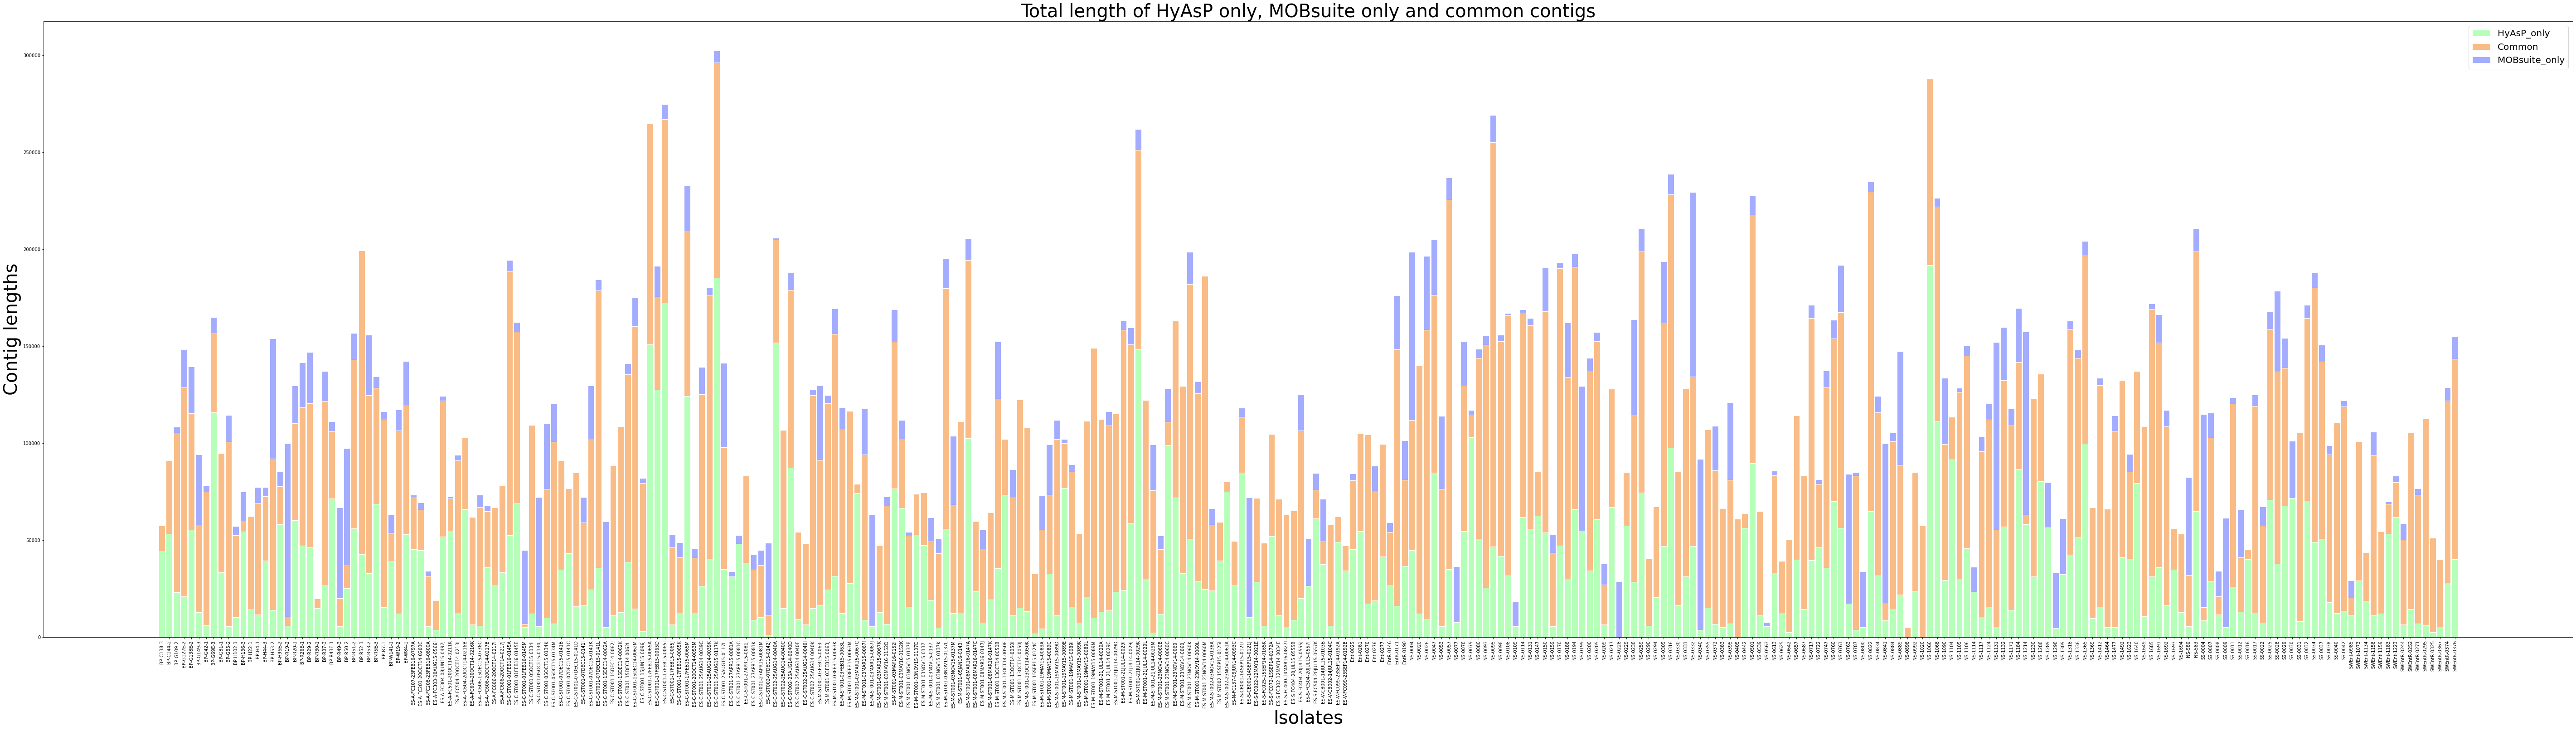

In [17]:
r = list(new_df['isolate'])        
greenBars = [i for i in new_df['greenBars']]
orangeBars = [i for i in new_df['orangeBars']]
blueBars = [i for i in new_df['blueBars']]
 
# plot
plt.figure(figsize=(100,25))
barWidth = 0.85
#names = sorted(list(common_isolates))
names = list(new_df['isolate'])
# Create green Bars
plt.bar(r, greenBars, color='#b5ffb9', edgecolor='white', width=barWidth, label='HyAsP_only')
# Create orange Bars
plt.bar(r, orangeBars, bottom=greenBars, color='#f9bc86', edgecolor='white', width=barWidth, label='Common')
# Create blue Bars
plt.bar(r, blueBars, bottom=[i+j for i,j in zip(greenBars, orangeBars)], color='#a3acff', edgecolor='white', width=barWidth, label='MOBsuite_only')
 
# Custom x axis
plt.xticks(r, names,rotation=90)
plt.ylabel('Contig lengths', fontsize=40)
plt.xlabel("Isolates", fontsize=40)
plt.legend(fontsize=20)
plt.title("Total length of HyAsP only, MOBsuite only and common contigs", fontsize=40)

 

Text(0.5, 1.0, 'Total length of HyAsP only, MOBsuite only and common contigs (Sorted by length)')

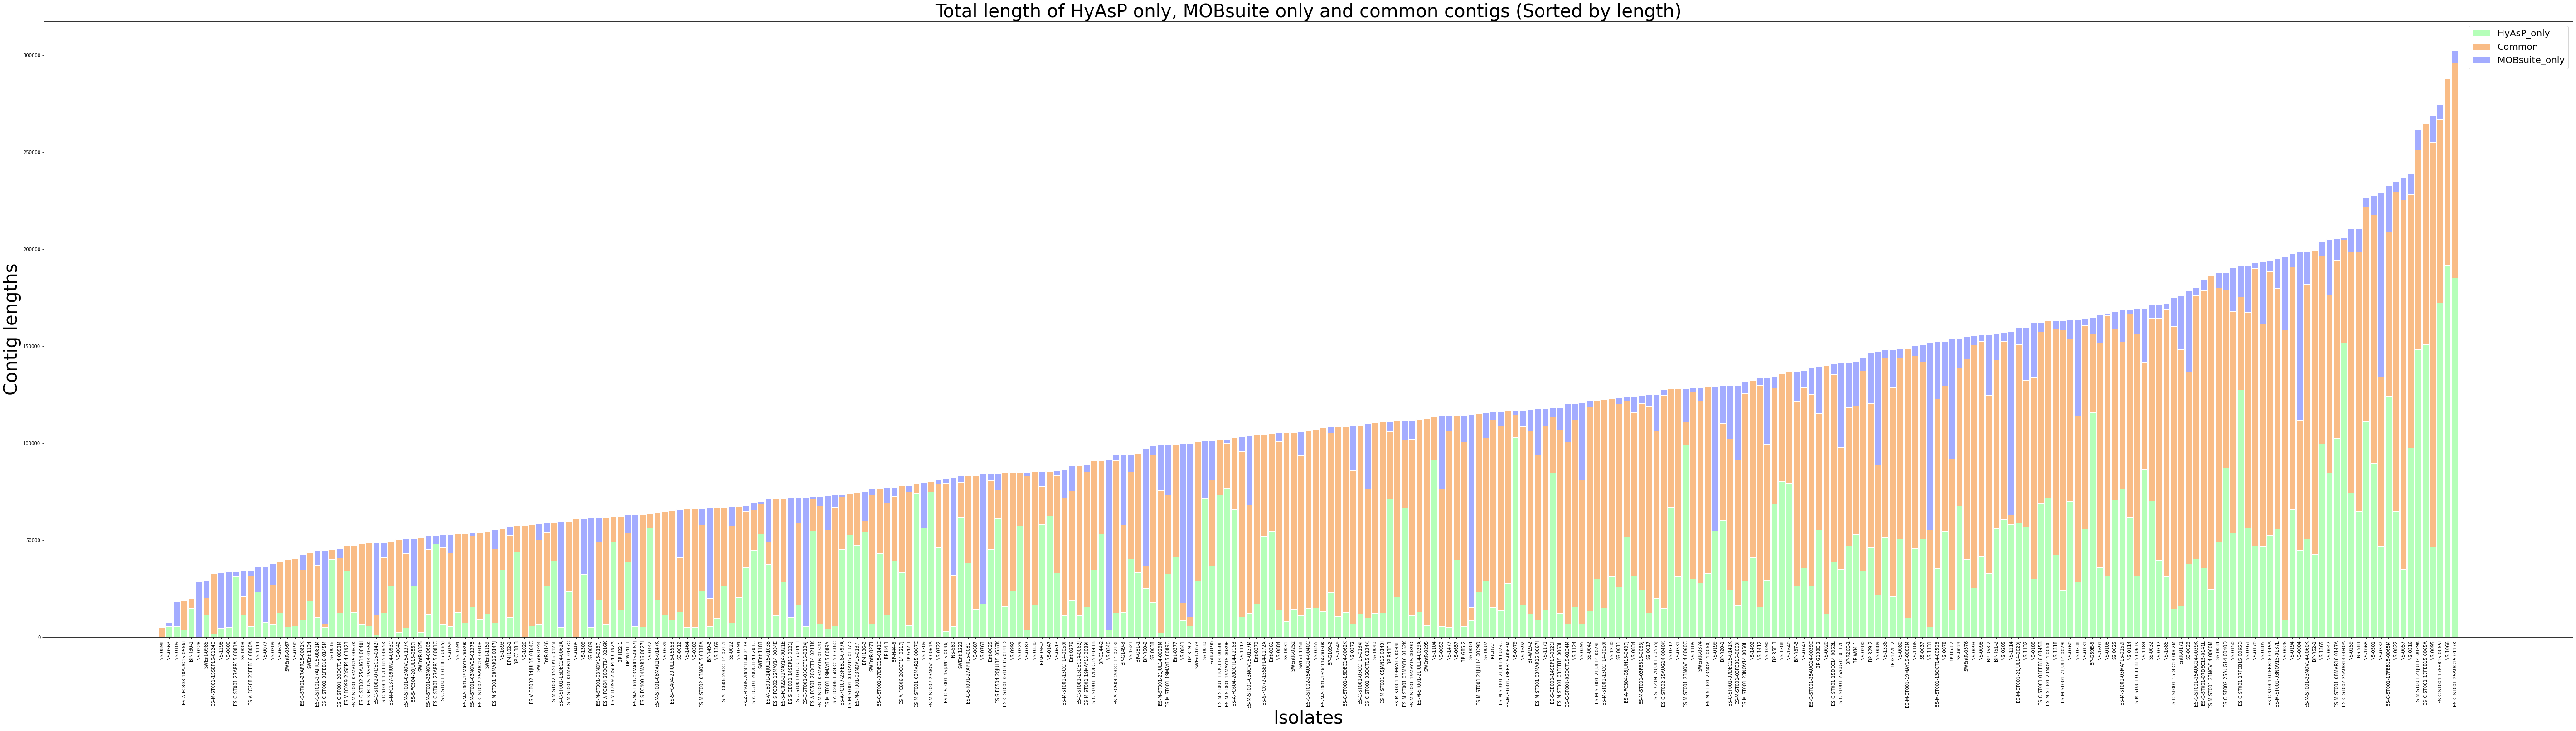

In [18]:
sorted_df = new_df.sort_values(by=['totals'])

r = list(sorted_df['isolate'])
greenBars = [i for i in sorted_df['greenBars']]
orangeBars = [i for i in sorted_df['orangeBars']]
blueBars = [i for i in sorted_df['blueBars']]
 
# plot
plt.figure(figsize=(100,25))
barWidth = 0.85
#names = sorted(list(common_isolates))
names = list(sorted_df['isolate'])
# Create green Bars
plt.bar(r, greenBars, color='#b5ffb9', edgecolor='white', width=barWidth, label='HyAsP_only')
# Create orange Bars
plt.bar(r, orangeBars, bottom=greenBars, color='#f9bc86', edgecolor='white', width=barWidth, label='Common')
# Create blue Bars
plt.bar(r, blueBars, bottom=[i+j for i,j in zip(greenBars, orangeBars)], color='#a3acff', edgecolor='white', width=barWidth, label='MOBsuite_only')

# Custom x axis
plt.xticks(r, names,rotation=90)
plt.ylabel('Contig lengths', fontsize=40)
plt.xlabel("Isolates", fontsize=40)
plt.legend(fontsize=20)
plt.title("Total length of HyAsP only, MOBsuite only and common contigs (Sorted by length)", fontsize=40)


In case of most of the isolates, both tools share a large proportion (in terms of length) of the contigs. 
However, in many cases, HyAsP tends to output more contigs that are not shared with MOBsuite solutions. 
This observation prompts the question if HyAsP outputs contigs that might not contain plasmidic genes. 
It also suggests that the dissimilarity between the two tools should be expected to be high for most isolates. 
No specific trend is observed when the isolates are grouped according to their nomenclatures (indicating the environment from which they were obtained) or when the isolates are sorted by length of the contigs.  

Note: The following isolates were left from the above graphs as they were outliers with very high total lengths relative to other isolates.

In [19]:
long_isolates

,isolate,greenBars,orangeBars,blueBars,totals
58,ES-C-ST001-07DEC15-0141J,1370915,148245,20512,1539672
295,SS-0039,184,67582,2890633,2958399


### HyAsP contigs with no plasmid genes

It may be possible for some tools (older versions of HyAsP) to output long contig chains with zero plasmid gene density as part of the solution. 
Hence, it is necessary to perform a sanity check for such tools to confirm that a significant portion of the contigs in predicted plasmid indeed contains plasmid genes. 
Here, we perform such a sanity check, we compute the plasmid gene coverage for each contig in an isolate. 
To obtain this statistic, we use the mapping details provided by HyAsP. (The file used to obtain these details: "ARETE_Efaecalis/HyAsP_17082020/results/isolate_id_assembly/isolate_id_assembly_gcm.csv")

We add the lengths of all the contigs that have zero plasmid gene coverage. We then divide this by the length of all the contigs to give us the proportion of the length that does not contain plasmid genes. 
Thus, if this ratio is low, it indicates that the plasmids output by HyAsP possess a significant amount of plasmid gene content. 
This was found to hold true for most isolates. 
For the isolates listed below, the plasmid gene content was less than 80% of the respective lengths. 

In [20]:
print("Isolate", "\t",colored("Gene-less contigs", "red"), "\t",colored("Total contigs", "blue"), "\t","Density")
for isolate in common_isolates:
    count = 0
    gene_free_len = 0
    total = 0
    total_len = 0
    for contig in HyAsP_contigs[isolate]:
        if HyAsP_contigs[isolate][contig]['Gene_coverage'] == 0:
            count += 1
            gene_free_len += HyAsP_contigs[isolate][contig]['length']
        total +=1
        total_len += HyAsP_contigs[isolate][contig]['length']
    if total_len != 0:
        if gene_free_len/total_len >= 0.2:
            print(isolate, "\t",colored(count, 'red'), "\t",colored(total, 'blue'), "\t",1-gene_free_len/total_len)


Isolate 	 Gene-less contigs 	 Total contigs 	 Density
ES-C-ST002-25AUG14-0040A 	 19 	 45 	 0.7376479658056269
ES-M-ST002-23NOV14-0061A 	 8 	 23 	 0.7113813035678693
NS-0079 	 7 	 18 	 0.6402561198710689
NS-0760 	 20 	 33 	 0.7952021496861796
ES-C-ST001-17FEB15-0065I 	 10 	 24 	 0.46648566667290803
ES-C-ST001-17FEB15-0065D 	 28 	 56 	 0.7912822090082701
ES-M-ST002-15SEP15-0125I 	 3 	 7 	 0.6837050492817978
NS-0834 	 4 	 17 	 0.7763936011326651
NS-1214 	 4 	 16 	 0.668866729977841
NS-1298 	 2 	 4 	 0.4136411332633788
BP-R29-2 	 8 	 25 	 0.7674233307050671
NS-1693 	 3 	 13 	 0.7710528189066059
NS-1365 	 12 	 29 	 0.6659768338197757
NS-0147 	 2 	 11 	 0.7964602803738318


### Dissimilarity between HyAsP and MOB-Suite results

The results we obtain with our dissimilarity measure indicate that both the tools tend to agree with each other's results for the most part. 
However, there are a few instances where the sets of contigs from the two solutions are mutually exclusive.

One important feature of our dissimilarity measure is that it accounts for the structural information provided by each method that groups contigs nto sets of predicted plasmids. 
A less refined dissimilarity measure could be based uniquely on the contig content of the predicted plasmids sets, using the symmetric difference between both sets (over all relabelling combinations to handle repeated contigs), again weighted by the length of the involved contigs and normalized by the sum of these lengths. 
Comparing our dissimilarity measure to the length-weighted symmetric difference allows us to obtain a lower bound on the dissmilarity measure, such that if the dissimilarity measure is close to this bound, we can assume that the two sets of predicted plasmids do differ mostly in terms of contigs content but not in terms of grouping of the common contigs, while conversely if the dissimilarity score is much higher than the lower bound, the sets of predicted plasmids differ greatly in terms of contigs grouping.

In [21]:
def get_sym_diff(length_dict):
    H_len = length_dict['H']
    M_len = length_dict['M']
    T_len = length_dict['T'] 
    comm_len = H_len + M_len - T_len
    return (H_len + M_len - 2*comm_len)/T_len

def get_decomp_ratios(decomp, score):
    total = 0
    for i in range(3):
        decomp[i] = float(decomp[i])
        total += decomp[i]
    for i in range(3):    
        if total != 0:    
            decomp[i] = (decomp[i]*score)/total
        else:
            decomp[i] = 0
    return decomp    
        

In [39]:
results_folder = '../results'
score_dict = {}
count = 0
flaws = 0
for file in os.listdir(results_folder):
    isolate_id = file.split("_")[0]
    filename = os.path.join(results_folder, file)
    str_list = read_file(filename)
    score = float(str_list[1].split("\t")[2])
    decomp = str_list[2].split("\t")[2].split("|")[0:3]
    
    if isolate_id in contig_lengths:
        if contig_lengths[isolate_id]['T'] <= 1000000:
            #print(isolate_id)
            score_dict[isolate_id] = {}
            score_dict[isolate_id]['Isolate'] = isolate_id
            score_dict[isolate_id]['Score'] = score
            score_dict[isolate_id]['H_len'] = contig_lengths[isolate_id]['H']
            score_dict[isolate_id]['M_len'] = contig_lengths[isolate_id]['M']
            score_dict[isolate_id]['T_len'] = contig_lengths[isolate_id]['T']
            score_dict[isolate_id]['Sym_diff'] = get_sym_diff(contig_lengths[isolate_id])
            decomp = get_decomp_ratios(decomp, score)
            score_dict[isolate_id]['H_cont'] = decomp[0]
            score_dict[isolate_id]['M_cont'] = decomp[1]
            score_dict[isolate_id]['Common_cont'] = decomp[2]
            
            
            if score == get_sym_diff(contig_lengths[isolate_id]):
                count += 1
            if score < get_sym_diff(contig_lengths[isolate_id]):
                flaws += 1                
            #print(score, get_sym_diff(contig_lengths[isolate_id]))
print("Sanity check - no. of times lower limit > dissimilarity: ", str(flaws)) 
print("No. of times dissimilarity equals set difference: ", str(count))     

score_dict = dict(sorted(score_dict.items()))
score_df = pd.DataFrame.from_dict(score_dict, orient='index')
#df = pd.DataFrame.from_dict(e, orient='index')

Sanity check - no. of times lower limit > dissimilarity:  0
No. of times dissimilarity equals set difference:  81


Clearly, for all isolates, the dissimilarity score is at least equal to the symmetric difference. Also, in 81 of the 313 isolates used in this analysis, the two are equal. 
This suggests that the structural differences in terms of contigs grouping play a considerable part in differentiating the solutions from the two tools. 

<Figure size 2880x1440 with 0 Axes>

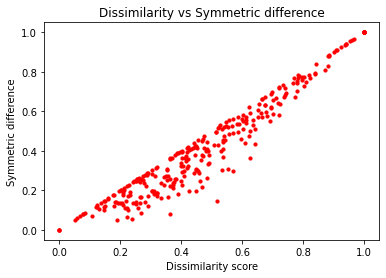

<Figure size 2880x1440 with 0 Axes>

In [40]:
a1 = list(score_df['Score'])
b1 = list(score_df['Sym_diff'])

plt.scatter(a1, b1, c='r',s=10)
plt.xlabel('Dissimilarity score')
plt.ylabel('Symmetric difference')
plt.title('Dissimilarity vs Symmetric difference')    
plt.figure(figsize=(40,20))

#### Dissimilarity scores analysis

In the figure below we provide a histogram of all pairwise dissimilarity scores obtained over the $313$ isolates of our dataset. 
We can observe a relatively normal distribution, aside of a set of 20 isolates with dissimilarity $1$ indicating total disagreement between the results of both tools, and that tends towards a mean score around $0.5$.

<Figure size 432x288 with 0 Axes>

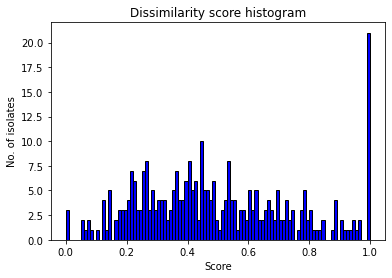

<Figure size 432x288 with 0 Axes>

In [41]:
plt.hist(score_df['Score'], color = 'blue', edgecolor = 'black',
         bins = 100)
plt.title('Dissimilarity score histogram')
plt.xlabel('Score')
plt.ylabel('No. of isolates')
plt.figure()

#### Dissimiliarity score vs contig lengths

The score tends to be closer to zero when the contig lengths are higher. 
On the other hand when the lengths are smaller they tend to disagree. 
The same trend is observed when the score is plotted against total length of HyAsP contigs, MOBsuite contigs and the overall length of contigs in the results of both tools.

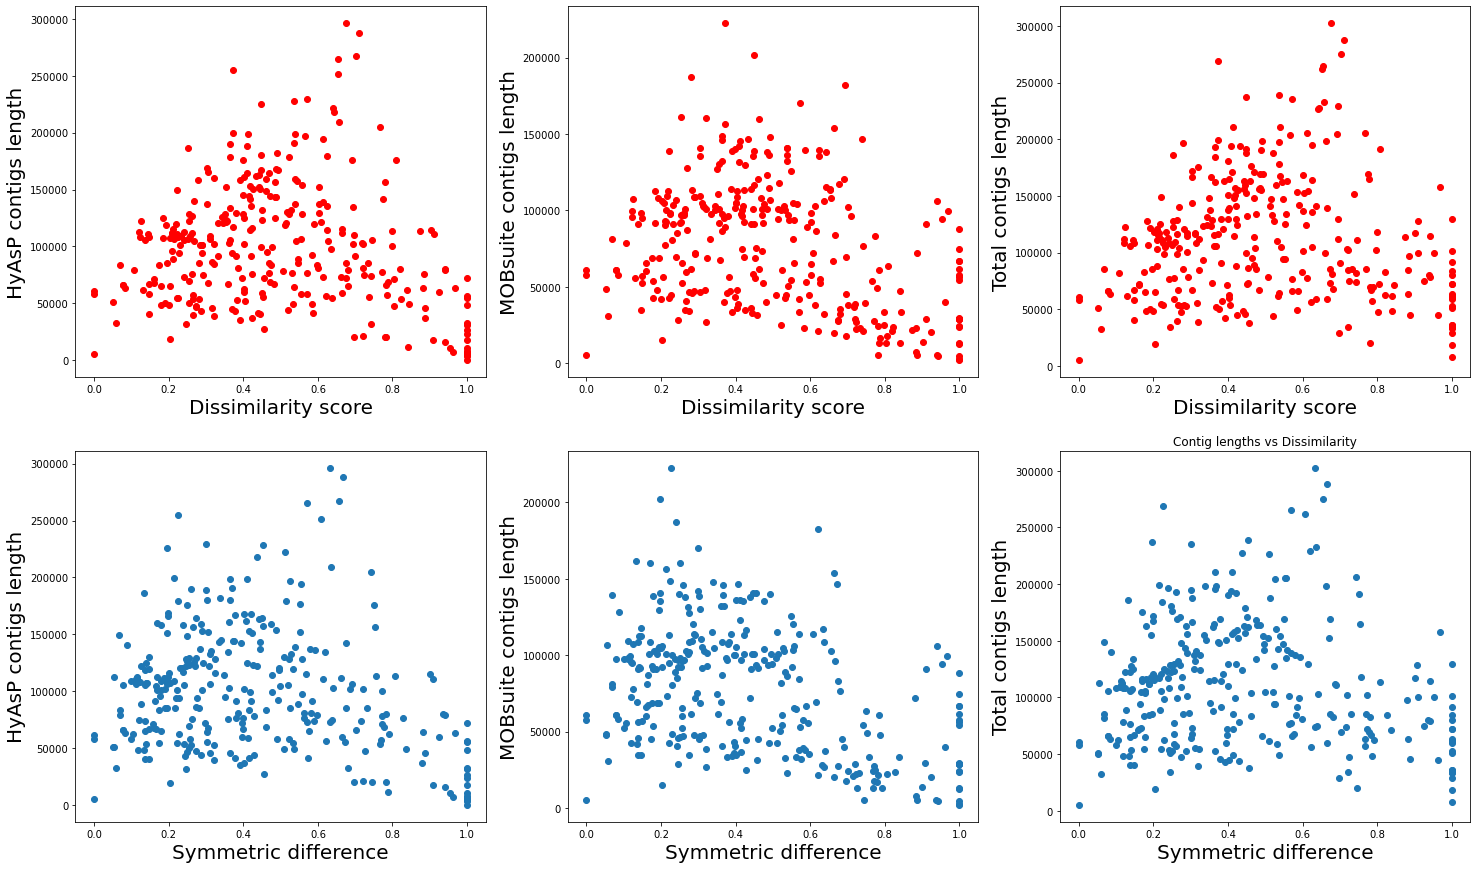

In [42]:
fig, axs = plt.subplots(2,3, figsize=(25,15))

a1 = list(score_df['Score'])
b1 = list(score_df['H_len'])

c1 = list(score_df['Score'])
d1 = list(score_df['M_len'])

e1 = list(score_df['Score'])
f1 = list(score_df['T_len'])

a2 = list(score_df['Sym_diff'])
b2 = list(score_df['H_len'])

c2 = list(score_df['Sym_diff'])
d2 = list(score_df['M_len'])

e2 = list(score_df['Sym_diff'])
f2 = list(score_df['T_len'])



axs[0,0].scatter(a1, b1, c='r')
axs[0,1].scatter(c1, d1, c='r')
axs[0,2].scatter(e1, f1, c='r')

axs[1,0].scatter(a2, b2)
axs[1,1].scatter(c2, d2)
axs[1,2].scatter(e2, f2)

for i in range(3):
    axs[0,i].set_xlabel('Dissimilarity score', fontsize=20)
    axs[1,i].set_xlabel('Symmetric difference', fontsize=20)
    
for i in range(2):
    axs[i,0].set_ylabel('HyAsP contigs length', fontsize=20)
    axs[i,1].set_ylabel('MOBsuite contigs length', fontsize=20)
    axs[i,2].set_ylabel('Total contigs length', fontsize=20)

plt.title('Contig lengths vs Dissimilarity')    
plt.show()



#### Contribution of HyAsP only, MOB-suite only and common contigs towards dissimilarity

It is important to understand if the introduced dissimilarity measure adds more information in differentiating the solutions rather than simply using the symmetric difference. 
The graphs above indicate that both show a similar trend. 
However, for most isolates, a high proportion of the total contig length consisted of contigs shared by both solutions. 
The dissimilarity score helps us comment on the structural similarity of the two solutions (limited to shared contigs). 
Simply knowing the symmetric difference does not provide this information. 

In the figure, below we compute the contribution of unique and shared contigs towards the dissimilarity. 
The dissimilarity score is a number between zero and one. 
We divide this score into three parts: contigs specific to HyAsP solutions (green), contigs specific to MOBsuite solutions (blue) and contigs common to both solutions (orange). 
The dissimilarity score is the length-weighted average of the the dissimilarity scores for each of the three parts. Let $S_H, S_M$ and $S_C$ be the dissimilarity score for three parts respectively and $L_H, L_M$ and $L_C$ be the total lengths of the contigs in each part. 
Thus, the overall dissimilarity score $D = (S_HL_H+S_ML_M+S_CL_C) / (L_H+L_M+L_C)$. 

Contigs specific to either tool have a dissimilarity score of 1. 
Thus, $S_H = S_M = 1$. Thus, $D = (L_H+L_M+S_CL_C)/(L_H+L_M+L_C)$. 
Thus, when the structures of the plasmids with respect to common contigs are similar, $S_C$ is almost zero and the dissimilarity is almost equal to the symmetric difference.

In the figure below, we see the contributions of each part to the dissimilarity. 
Thus, the height of the green portion of the bars is equal to $L_H/(L_H+L_M+L_C)$, blue portion is equal to $L_M/(L_H+L_M+L_C)$ and the orange portion is $S_CL_C/(L_H+L_M+L_C)$. 
Looking at the figure below, it is clear that the orange portion is relatively small compared to the other two. 
This reiterates the information that differences in the solutions from HyAsP and MOBsuite mostly result from contigs specific to the two solutions. 
Furthermore, the two tools generally agree with the compositions of the plasmids considering the contigs common to both solutions.

Text(0.5, 1.0, 'Contribution of HyAsP only, MOBsuite only and common contigs towards dissimilarity')

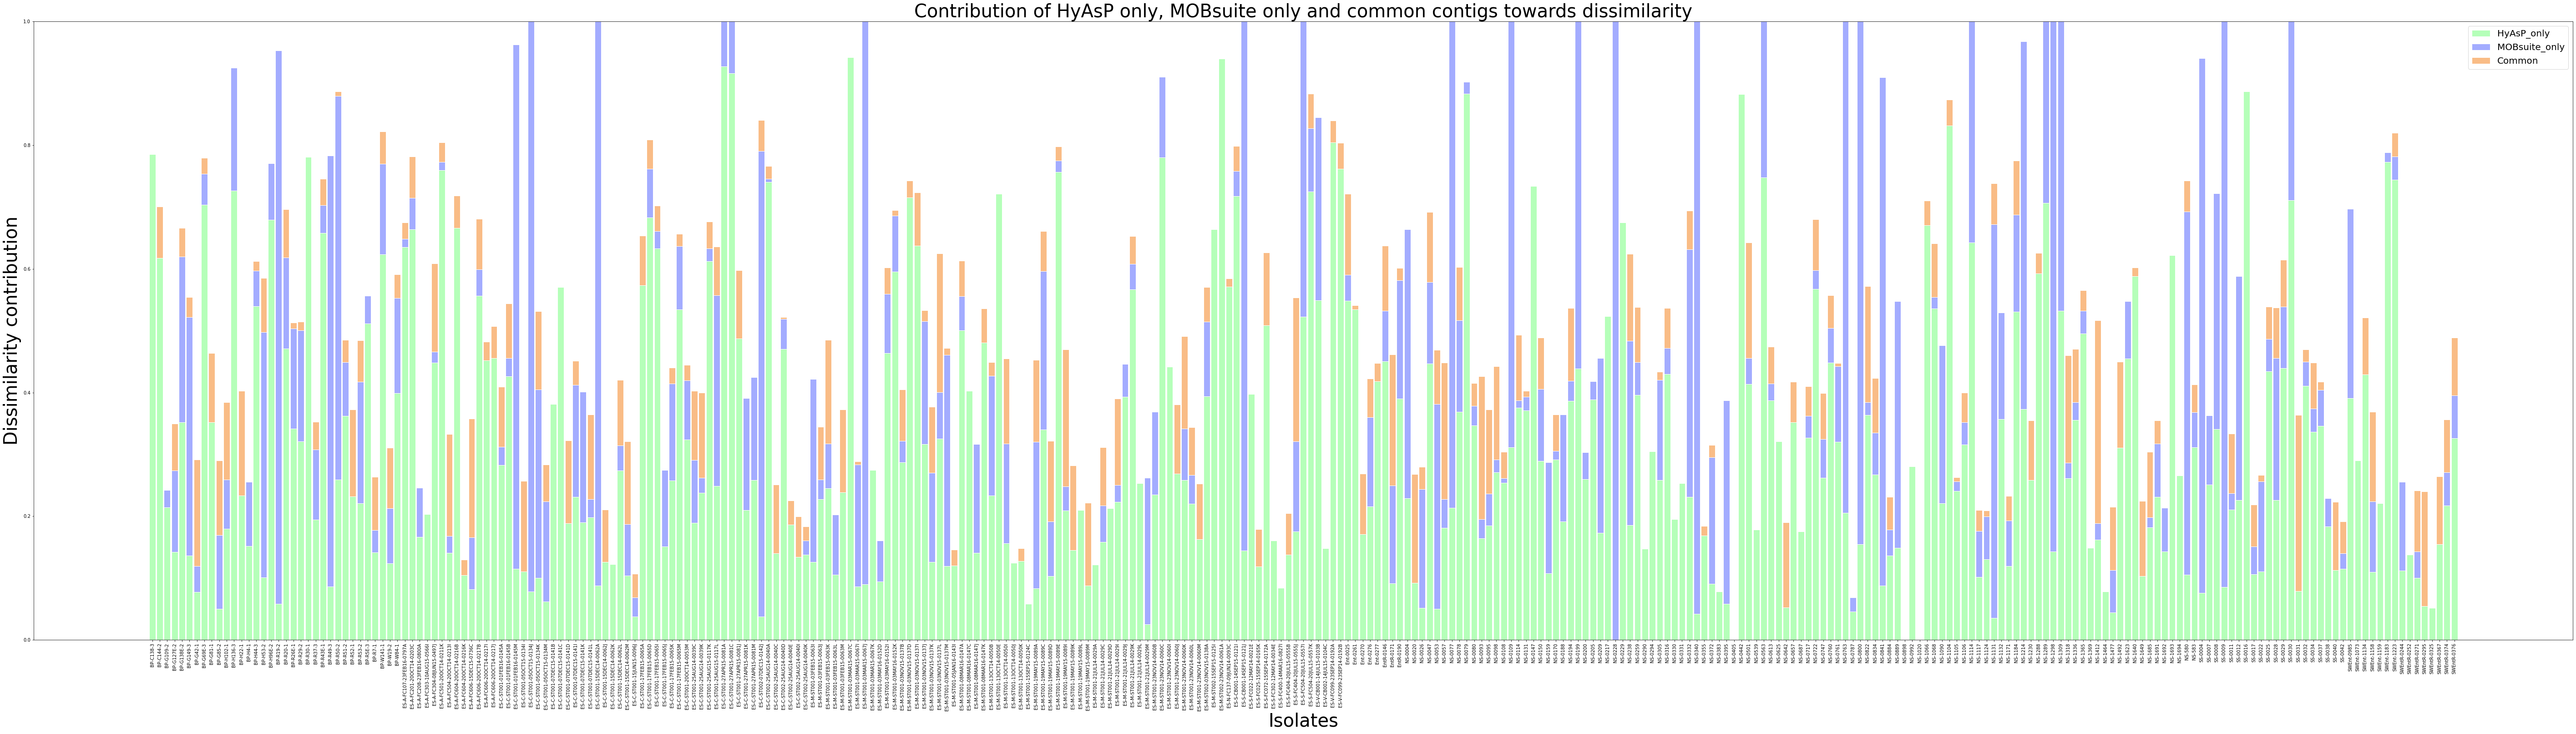

In [43]:
r = list(score_df['Isolate'])        
greenBars = [i for i in score_df['H_cont']]
blueBars = [i for i in score_df['M_cont']]
orangeBars = [i for i in score_df['Common_cont']]


# plot
plt.figure(figsize=(100,25))
barWidth = 0.85
names = list(new_df['isolate'])
# Create green Bars
plt.bar(r, greenBars, color='#b5ffb9', edgecolor='white', width=barWidth, label='HyAsP_only')
# Create orange Bars
plt.bar(r, blueBars, bottom=greenBars, color='#a3acff', edgecolor='white', width=barWidth, label='MOBsuite_only')
# Create blue Bars
plt.bar(r, orangeBars, bottom=[i+j for i,j in zip(greenBars, blueBars)], color='#f9bc86', edgecolor='white', width=barWidth, label='Common')
 
# Custom x axis
plt.xticks(r, names,rotation=90)

plt.ylabel('Dissimilarity contribution', fontsize=40)
plt.xlabel("Isolates", fontsize=40)
plt.legend(fontsize=20)
plt.title("Contribution of HyAsP only, MOBsuite only and common contigs towards dissimilarity", fontsize=40)


## Conclusion

We introduced a dissimilarity measure to compare two sets of predicted plasmids, each represented as a set of multi-sets of contigs.  
This measure improves on the contigs content symmetric difference in that it accounts for the grouping of contigs into plasmid groups.  
We applied this method to the predicted plasmids of $313$ *E. faecalis* isolates by the methods HyAsP and MOB-suite.  
We can observe that the main reason for disagreement between both methods is due to the set of included contigs in each prediction more than the structure of the grouping of common contigs.  
This suggests that the subsets of common contigs between both methods likely represent prediction that can be considered with higher confidence, while method-specific contigs are to be considered with less confidence. 
We can also observe that HyAsP generally includes more contigs than MOB-suite, likely suggesting that the method is less specific.